In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
def create_features(df):
    
    # This function creates time series features based on the date of recording
    
    df = df.copy()
    
    df['DayofWeek']= df.index.dayofweek
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['DayofYear'] = df.index.dayofyear
    
    return df

In [3]:
produce_data = pd.read_csv('/Users/ajarbuckle/Desktop/Produce Project/Original Data/produce_price_timeseries.csv')

# Getting rid of unnecessary columns 
produce_data = produce_data[['Commodity', 'Date', 'Average']]

# Changing some column names 
produce_data.rename(columns={'Average': 'Price', 'Commodity': 'Item'}, inplace=True)

produce_data

,Item,Date,Price
0,Tomato Big(Nepali),2013-06-16,37.5
1,Tomato Small(Local),2013-06-16,29.0
2,Potato Red,2013-06-16,20.5
3,Potato White,2013-06-16,15.5
4,Onion Dry (Indian),2013-06-16,29.0
...,...,...,...
197156,Garlic Dry Nepali,2021-05-13,110.0
197157,Fish Fresh(Rahu),2021-05-13,275.0
197158,Fish Fresh(Bachuwa),2021-05-13,230.0
197159,Fish Fresh(Chhadi),2021-05-13,225.0


In [4]:
# Making sure that the 'Date' column is a date variable

produce_data['Date'] = pd.to_datetime(produce_data['Date'])
produce_data.dtypes

Item             object
Date     datetime64[ns]
Price           float64
dtype: object

In [5]:
# Setting the 'Date' column to be the index of the dataframe; this is necessary for time series analyses

produce_data.set_index('Date', inplace=True)
produce_data

,Item,Price
Date,,
2013-06-16,Tomato Big(Nepali),37.5
2013-06-16,Tomato Small(Local),29.0
2013-06-16,Potato Red,20.5
2013-06-16,Potato White,15.5
2013-06-16,Onion Dry (Indian),29.0
...,...,...
2021-05-13,Garlic Dry Nepali,110.0
2021-05-13,Fish Fresh(Rahu),275.0
2021-05-13,Fish Fresh(Bachuwa),230.0


In [6]:
# Splitting the dataframe up by item 

okara = produce_data[produce_data['Item'] == 'Okara']
okara

,Item,Price
Date,,
2013-06-16,Okara,22.5
2013-06-17,Okara,20.0
2013-06-18,Okara,22.5
2013-06-19,Okara,37.5
2013-06-20,Okara,37.5
...,...,...
2021-05-09,Okara,25.0
2021-05-10,Okara,55.0
2021-05-11,Okara,55.0


In [7]:
# Interpolating because there are some missing days, and the analysis won't work without complete data 

okara = okara.resample('D').interpolate()
okara 

,Item,Price
Date,,
2013-06-16,Okara,22.5
2013-06-17,Okara,20.0
2013-06-18,Okara,22.5
2013-06-19,Okara,37.5
2013-06-20,Okara,37.5
...,...,...
2021-05-09,Okara,25.0
2021-05-10,Okara,55.0
2021-05-11,Okara,55.0


<AxesSubplot:title={'center':'Okara Prices Over Time'}, xlabel='Date'>

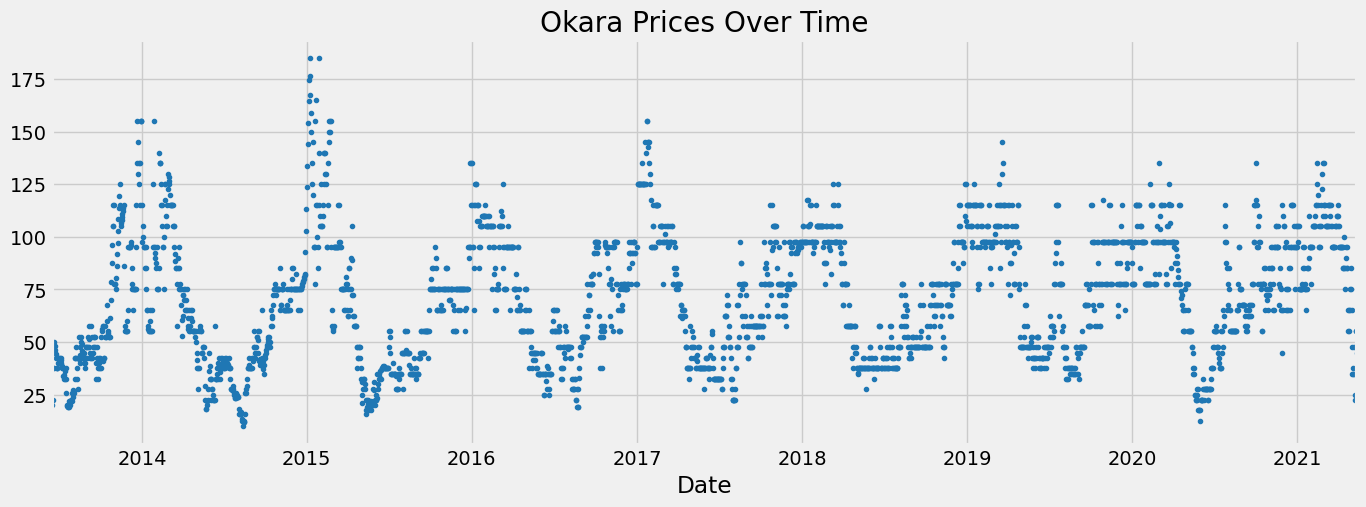

In [8]:
# Visualizing the time series data

okara.plot(style = '.', figsize = (15,5), color = color_pal[0], title = 'Okara Prices Over Time', legend = False)

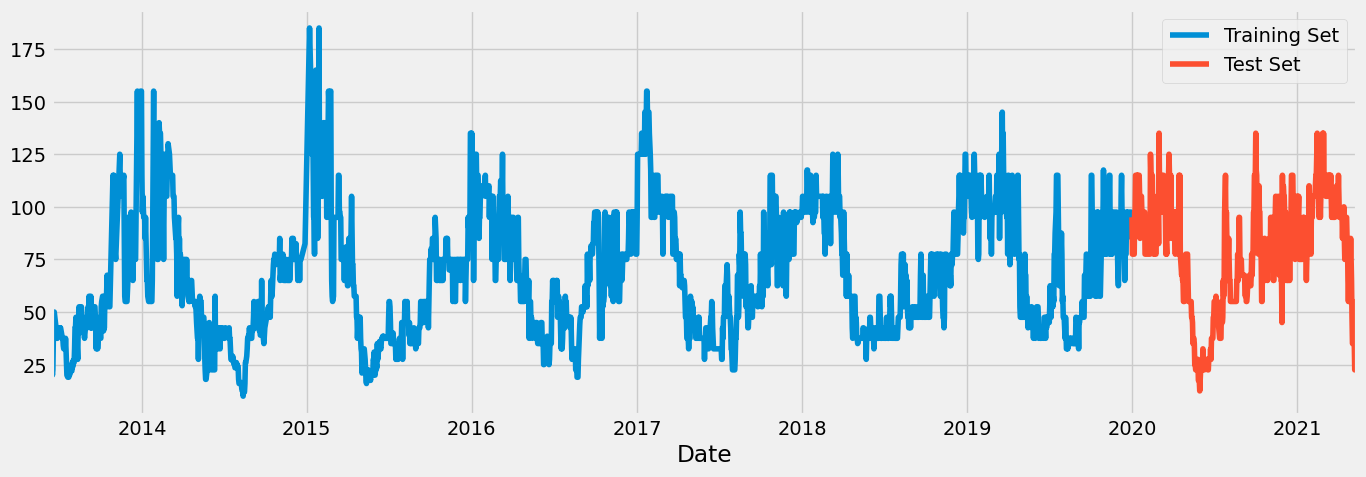

In [9]:
# Creating training and test sets; training set will be all data before 2020, test set wil be all data after 2020
train = okara.loc[okara.index <= '2019-12-31']
test = okara.loc[okara.index > '2019-12-31']

# Visualizing
fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax = ax, label = 'Training Set')
test.plot(ax = ax, label = 'Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [10]:
# Adding in the time series features to the original dataframe (before splitting into training and test sets) 
# to make sure that it's working properly 

okara = create_features(okara)
okara

,Item,Price,DayofWeek,Month,Year,DayofYear
Date,,,,,,
2013-06-16,Okara,22.5,6,6,2013,167
2013-06-17,Okara,20.0,0,6,2013,168
2013-06-18,Okara,22.5,1,6,2013,169
2013-06-19,Okara,37.5,2,6,2013,170
2013-06-20,Okara,37.5,3,6,2013,171
...,...,...,...,...,...,...
2021-05-09,Okara,25.0,6,5,2021,129
2021-05-10,Okara,55.0,0,5,2021,130
2021-05-11,Okara,55.0,1,5,2021,131


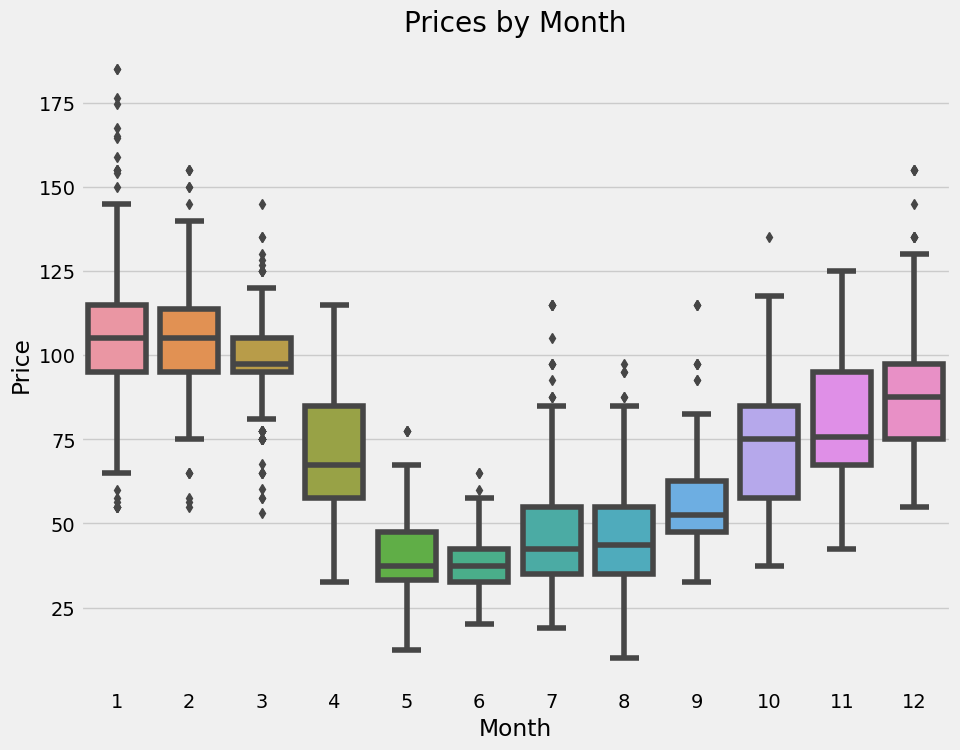

In [11]:
# Creating boxplots of prices per month

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=okara, x='Month', y='Price')
ax.set_title('Prices by Month')
plt.show()

In [12]:
# Creating the time series features in the training and test sets 

train = create_features(train)
test = create_features(test)

In [13]:
# Labeling out feature and target variables

FEATURES = ['DayofWeek', 'Month', 'Year', 'DayofYear']
TARGET = 'Price'

In [14]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
# Creating the model 

reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
reg.fit(x_train, y_train,
        eval_set = [(x_train, y_train), (x_test, y_test)],
        verbose = 100)

[0]	validation_0-rmse:29.56635	validation_1-rmse:28.53811
[100]	validation_0-rmse:15.89008	validation_1-rmse:18.60370
[200]	validation_0-rmse:11.40377	validation_1-rmse:18.09850
[209]	validation_0-rmse:11.18501	validation_1-rmse:18.14958


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
# Feature importance 

fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
             columns = ['importance'])
fi.sort_values(by = 'importance', ascending = False)

,importance
DayofYear,0.627669
Month,0.246199
Year,0.114221
DayofWeek,0.011911


<AxesSubplot:title={'center':'Feature Importance'}>

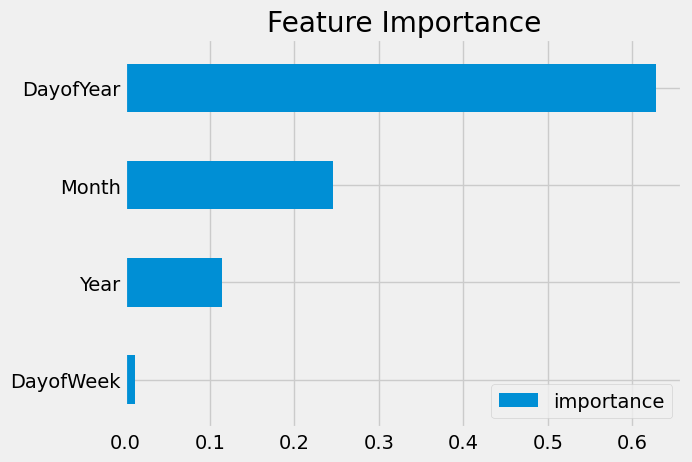

In [17]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')

In [18]:
# Creating a new column in the test dataframe that stores the value that our model predicted for each date

test['prediction'] = reg.predict(x_test)
test

,Item,Price,DayofWeek,Month,Year,DayofYear,prediction
Date,,,,,,,
2020-01-01,Okara,95.0,2,1,2020,1,99.453056
2020-01-02,Okara,77.5,3,1,2020,2,99.453056
2020-01-03,Okara,77.5,4,1,2020,3,99.453056
2020-01-04,Okara,77.5,5,1,2020,4,99.453056
2020-01-05,Okara,77.5,6,1,2020,5,99.453056
...,...,...,...,...,...,...,...
2021-05-09,Okara,25.0,6,5,2021,129,53.721340
2021-05-10,Okara,55.0,0,5,2021,130,53.721340
2021-05-11,Okara,55.0,1,5,2021,131,53.721340


In [19]:
# Taking the predicted values and merging them into the original dataframe so we can see the predicted values and the 
# actual values side by side 

okara = okara.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)
okara

,Item,Price,DayofWeek,Month,Year,DayofYear,prediction
Date,,,,,,,
2013-06-16,Okara,22.5,6,6,2013,167,NaN
2013-06-17,Okara,20.0,0,6,2013,168,NaN
2013-06-18,Okara,22.5,1,6,2013,169,NaN
2013-06-19,Okara,37.5,2,6,2013,170,NaN
2013-06-20,Okara,37.5,3,6,2013,171,NaN
...,...,...,...,...,...,...,...
2021-05-09,Okara,25.0,6,5,2021,129,53.721340
2021-05-10,Okara,55.0,0,5,2021,130,53.721340
2021-05-11,Okara,55.0,1,5,2021,131,53.721340


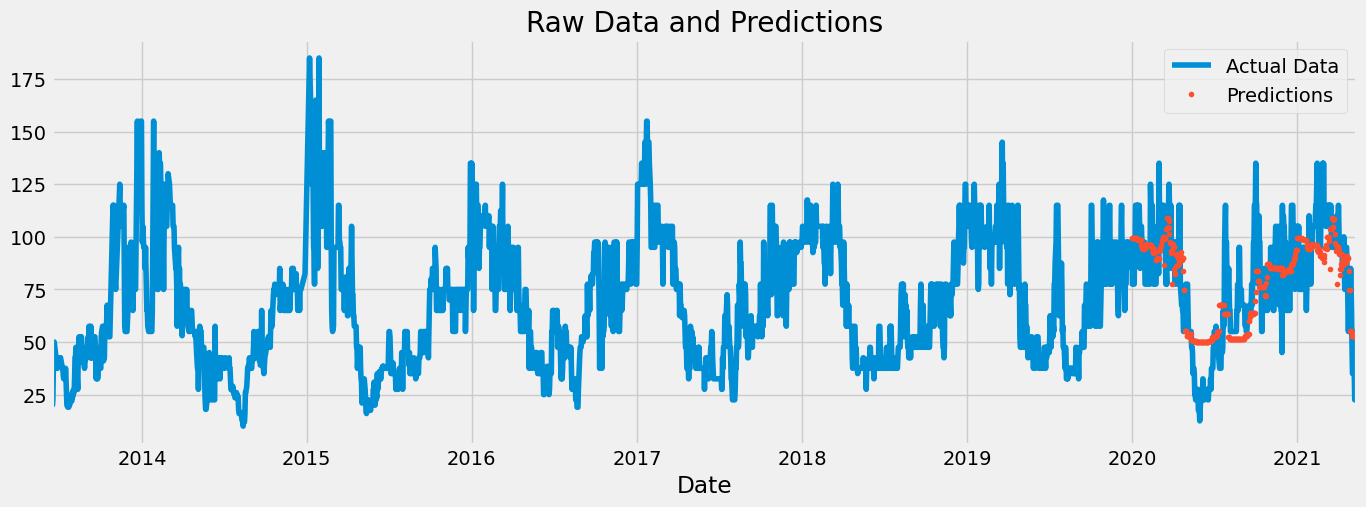

In [20]:
# Visualizing the predicted values on top of the actual values 

ax = okara[['Price']].plot(figsize = (15, 5))
okara['prediction'].plot(ax = ax, style = '.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

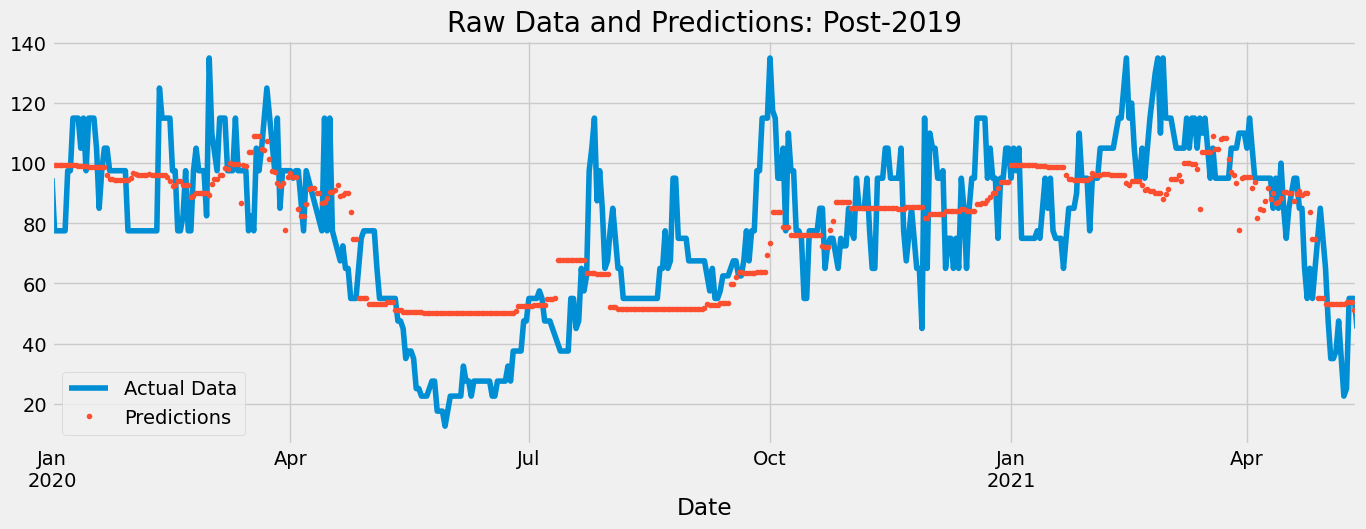

In [21]:
# Visualizing the predicted values on top of the actual values for the year of 2020 only 

ax = okara.loc[okara.index > '2019-12-31']['Price'] \
    .plot(figsize=(15, 5), title='Post-2019 Data')
okara.loc[okara.index > '2019-12-31']['prediction'] \
    .plot(style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Data and Predictions: Post-2019')
plt.show()

In [22]:
# Calculating accuracy of model (root mean squared error; same metric used to evaluate model as it trained

eval_score = np.sqrt(mean_squared_error(test[TARGET], test['prediction']))
print(f'RMSE Score on Test set: {eval_score:0.2f}')

RMSE Score on Test set: 17.92


In [23]:
# Calculating error of model as a new column on our test dataframe

test['error'] = np.abs(test[TARGET] - test['prediction'])
test

,Item,Price,DayofWeek,Month,Year,DayofYear,prediction,error
Date,,,,,,,,
2020-01-01,Okara,95.0,2,1,2020,1,99.453056,4.453056
2020-01-02,Okara,77.5,3,1,2020,2,99.453056,21.953056
2020-01-03,Okara,77.5,4,1,2020,3,99.453056,21.953056
2020-01-04,Okara,77.5,5,1,2020,4,99.453056,21.953056
2020-01-05,Okara,77.5,6,1,2020,5,99.453056,21.953056
...,...,...,...,...,...,...,...,...
2021-05-09,Okara,25.0,6,5,2021,129,53.721340,28.721340
2021-05-10,Okara,55.0,0,5,2021,130,53.721340,1.278660
2021-05-11,Okara,55.0,1,5,2021,131,53.721340,1.278660


In [24]:
# Seeing which months our model predicts the best for 

test.groupby('Month')['error'].mean().sort_values()

Month
3     12.284724
1     12.740372
4     12.743297
11    13.027432
10    13.631532
12    13.950343
8     14.187932
9     14.785997
2     15.966530
5     16.041433
7     16.180170
6     21.331361
Name: error, dtype: float64

In [25]:
# Evaluating the model against a comparison model: predictions that are just the average for each month from the training set

# Creating a new dataframe that holds this information

# Getting just the month and price columns from the training set dataframe
monthly_averages = train[['Month', 'Price']]
monthly_averages = monthly_averages.reset_index(drop=True)

# Calculating the average price for each month 
monthly_averages = monthly_averages.groupby('Month')['Price'].mean().reset_index()
monthly_averages

,Month,Price
0,1,110.092742
1,2,103.276627
2,3,96.193548
3,4,67.093056
4,5,39.435484
5,6,38.206410
6,7,44.468894
7,8,42.140553
8,9,52.597619
9,10,72.267281


In [26]:
# Merging monthly average information into the test dataframe to be able to calculate the comparison model's errors

# Renaming 'Price' column in monthly_averages dataframe to 'CompPrediction' so that the original Price column name isn't changed 
monthly_averages.rename(columns = {'Price': 'CompPrediction'}, inplace = True)

test = test.merge(monthly_averages, on='Month', how='left')
test

,Item,Price,DayofWeek,Month,Year,DayofYear,prediction,error,CompPrediction
0,Okara,95.0,2,1,2020,1,99.453056,4.453056,110.092742
1,Okara,77.5,3,1,2020,2,99.453056,21.953056,110.092742
2,Okara,77.5,4,1,2020,3,99.453056,21.953056,110.092742
3,Okara,77.5,5,1,2020,4,99.453056,21.953056,110.092742
4,Okara,77.5,6,1,2020,5,99.453056,21.953056,110.092742
...,...,...,...,...,...,...,...,...,...
494,Okara,25.0,6,5,2021,129,53.721340,28.721340,39.435484
495,Okara,55.0,0,5,2021,130,53.721340,1.278660,39.435484
496,Okara,55.0,1,5,2021,131,53.721340,1.278660,39.435484
497,Okara,55.0,2,5,2021,132,51.180122,3.819878,39.435484


In [27]:
# Calculating the comparison model's error
test['CompError'] = np.abs(test[TARGET] - test['CompPrediction'])
test

,Item,Price,DayofWeek,Month,Year,DayofYear,prediction,error,CompPrediction,CompError
0,Okara,95.0,2,1,2020,1,99.453056,4.453056,110.092742,15.092742
1,Okara,77.5,3,1,2020,2,99.453056,21.953056,110.092742,32.592742
2,Okara,77.5,4,1,2020,3,99.453056,21.953056,110.092742,32.592742
3,Okara,77.5,5,1,2020,4,99.453056,21.953056,110.092742,32.592742
4,Okara,77.5,6,1,2020,5,99.453056,21.953056,110.092742,32.592742
...,...,...,...,...,...,...,...,...,...,...
494,Okara,25.0,6,5,2021,129,53.721340,28.721340,39.435484,14.435484
495,Okara,55.0,0,5,2021,130,53.721340,1.278660,39.435484,15.564516
496,Okara,55.0,1,5,2021,131,53.721340,1.278660,39.435484,15.564516
497,Okara,55.0,2,5,2021,132,51.180122,3.819878,39.435484,15.564516


In [28]:
# Calculating RMSE for the comparison model 
comp_eval_score = np.sqrt(mean_squared_error(test[TARGET], test['CompPrediction']))
print(f'RMSE Score on Test set: {comp_eval_score:0.2f}')

RMSE Score on Test set: 20.19


In [29]:
# Calculating how much more accurate our model is than the comparison model 
percentage_difference = ((comp_eval_score - eval_score) / comp_eval_score) * 100
print(f'Our model is {percentage_difference:f}% more accurate than the comparison model')

Our model is 11.252914% more accurate than the comparison model
